# CEREBRUM - iPython Notebook Demo (testing)
<br>
Testing of the fully-volumetric model introduced in:

<b><font size="4">[CEREBRUM: a fast and fully-volumetric Convolutional Encoder-decodeR for weakly supervised sEgmentation of BRain strUctures from out-of-the-scanner MRI](https://www.sciencedirect.com/science/article/pii/S1361841520300542)</font></b>


Enjoy! 😃

---

This third notebook elaborates on the testing phase, covering how to use CEREBRUM to segment previously unseen MRI data.

In [1]:
# specify the location of the library
lib_path = '.'

import os

import sys
sys.path.insert(0, lib_path)

import numpy as np
import nibabel as nib
import argparse
import json
import time

from keras.models import load_model
from keras.utils import np_utils


import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

%matplotlib inline

from matplotlib.colors import ListedColormap


# import the CEREBRUM library
from cer3brum_lib.vol_losses import losses_dict
from cer3brum_lib import utils
from cer3brum_lib.fully_vol import cer3brum

# limit the number of usable GPUs to one
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


Set the user-defined variables so that they match the combination chosen for the training phase:

In [2]:
# tuple containing the dimension of each volume (tuple of three integers)
data_dims = (192, 256, 168)

# for sake of clarity in the following code, define:
num_slices_sag = data_dims[0]
num_slices_cor = data_dims[1]
num_slices_lon = data_dims[2]

# (str)
dataset_name = 'glasgow/3T/'

# (bool)
use_standardisation = True


# (str)
anat_suffix = '_T1w.nii.gz'

# (str)
segm_suffix = '_segm_c3rebrum.nii.gz'

# (int) in our case, only T1w was used
num_sequences = 1

# (int) in our case, the model was trained to segment eight different classes
num_segmask_labels = 8

As for the training notebook, there are a few command line parameters that can be changed:

- `export_prob_maps` is a boolean specifying whether or not the soft segmentation maps should be exported along with the hard segmentation;
- `model_name` is a string containing the name of the model used for the inference.

In [3]:
# (boolean)
export_prob_maps = True

# (string)
model_name = 'your_trained_instance_of_c3rebrum.h5'

models_dir = os.path.join('../output/models', dataset_name)
model_path = os.path.join(models_dir, model_name)

In [20]:
# change this to match your testing data location
data_path = os.path.join('../../data', dataset_name)
openneuro_data_path = '../../data/openneuro-release'


# specify the folders containing the training set and the validation set
testing_path = os.path.join(data_path, 'openneuro-release')

# load the model together with the custom metrics used during training
model = load_model(model_path,
                   custom_objects = {'categorical_crossentropy'      : 'categorical_crossentropy',
                                     'dice_coef_multilabel'          : losses_dict['multiclass_dice_coeff'],
                                     'average_dice_coef_multilabel'  : losses_dict['average_multiclass_dice_coeff'],
                                     'weighted_dice_coef_multilabel' : losses_dict['weighted_multiclass_dice_coeff'],
                                     'tanimoto_coefficient'          : losses_dict['tanimoto_coefficient'],
                                    })

We define again a couple of useful function (for sake of clarity):

In [5]:
# check volume integrity (presence of NaN and inf could arise during the standardisation)
def check_vol_integrity(input_vol, vol_name):

    if np.sum(np.isnan(input_vol)) != 0:
        print('WARNING: %d NaN(s) found in volume "%s"!'%(np.sum(np.isnan(input_vol)), vol_name))
        sys.exit(0)
        
    if np.sum(np.isinf(input_vol)) != 0:
        print('WARNING: %d inf(s) found in volume "%s"!'%(np.sum(np.isinf(input_vol)), vol_name))
        sys.exit(0)

## ----------------------------------------

# volumes z-scoring 
def volume_zscoring(input_vol, voxelwise_mean, voxelwise_std):

    # standardize each training volume
    input_vol -= voxelwise_mean
    input_vol /= voxelwise_std
    
    return input_vol

Load the voxelwise mean and standard deviation and the testing volume, then z-score the latter:

In [21]:
zscoring_path = os.path.join('../output/zscoring', dataset_name)

voxelwise_mean_path = os.path.join(zscoring_path, 'voxelwise_mean.nii.gz')
voxelwise_std_path  = os.path.join(zscoring_path, 'voxelwise_std.nii.gz')

# to make the data suitable for pooling, reduce the last dimension so that it can be divided by 2^3
voxelwise_mean = np.array(nib.load(voxelwise_mean_path).dataobj[:, :, 0:168]).astype(dtype = 'float32')
voxelwise_std = np.array(nib.load(voxelwise_std_path).dataobj[:, :, 0:168]).astype(dtype = 'float32')

# zero-padding is added by some pipelines at the borders, thus the voxelwise variability
# would result zero. Change these positions to 1 in order to mantain the zero in the division
voxelwise_std[voxelwise_std == 0] = 1

vol_to_segment = 'sub-01'

mri_path = os.path.join(testing_path, vol_to_segment, vol_to_segment + anat_suffix)

# to make the data suitable for pooling, reduce the last dimension so that it can be divided by 2^3
mri = np.array(nib.load(mri_path).dataobj[:, :, :168]).astype(dtype = 'float32')


anon_mri_path = os.path.join(openneuro_data_path, vol_to_segment, 'anat', vol_to_segment + anat_suffix)

# to make the data suitable for pooling, reduce the last dimension so that it can be divided by 2^3
anon_mri = np.array(nib.load(anon_mri_path).dataobj[:, :, :168]).astype(dtype = 'float32')


# check if everything is ok
if mri.shape != data_dims:
    print('\n Warning: volume "%s" size mismatch: have you checked the testing volume...'%(vol_name))
    
assert mri.shape == data_dims

zscored_mri = np.copy(mri)

if use_standardisation == True:
    zscored_mri = volume_zscoring(zscored_mri, voxelwise_mean, voxelwise_std)

<b>N.B.</b>

The instance of CEREBRUM we provide (and use in the context of this Jupyter Notebook) was not trained on anonymised data, but rather on reconstructed DICOMs. All the data we share via OpenNeuro, on the other hand, are anonymised for privacy reasons.

The segmentation masks we use in the following are nonetheless obtained starting from the non-anonymised data - but for the purpose of this notebook, we superimpose them to the anonymised data for the sake of clarity.

In [7]:
# check if everything is ok
check_vol_integrity(zscored_mri, vol_to_segment)

# initialize the numpy volume containing the volume to test
x_test = np.zeros((num_slices_sag, num_slices_cor, num_slices_lon, num_sequences), dtype=np.float)

# initialize the numpy volume containing the actual segmentation mask (if present)
y_test = np.zeros((num_slices_sag, num_slices_cor, num_slices_lon, num_segmask_labels), dtype=np.uint8)

# initialize the numpy volumes that will contain the network prediction and its thresholding
y_test_prob_map = np.zeros((num_slices_sag, num_slices_cor, num_slices_lon, num_segmask_labels), dtype=np.float)
y_test_pred     = np.zeros((num_slices_sag, num_slices_cor, num_slices_lon, num_segmask_labels), dtype=np.uint8)

x_test[:, :, :, 0] = zscored_mri

# keep T1 header (later use)
vol_header = nib.load(mri_path).header

# start timer
start_time = time.time()

y_test_prob_map = np.squeeze(model.predict(np.expand_dims(x_test, axis=0), verbose = True))

elapsed_time = time.time() - start_time

print('\nDone in %3.2f seconds.'%(elapsed_time))

1/1 [==============================] - 8s 8s/step

Done in 7.89 seconds.


In the inference phase, the model outputs a 4D-tensor shaped as the input data but with as many channels as the segmented classes. Every voxel of such volume stores the probability that the former belongs to a given class. We can visualise some probability maps, comparing and superimposing them to the anatomical T1w data.

For the sake of clarity, define a couple of variables (lookup table, color map, slice numbers) to make the visualisation easier:

In [14]:
classes_list = [
                "background",
                "gray matter",
                "basal ganglia",
                "white matter",
                "cerebrospinal fluid",
                "ventricles",
                "cerebellum",
                "brainstem",
               ]

segm_lut = {
            "background"          : 0,
            "gray matter"         : 1,
            "basal ganglia"       : 2,
            "white matter"        : 3,
            "cerebrospinal fluid" : 4,
            "ventricles"          : 5,
            "cerebellum"          : 6,
            "brainstem"           : 7,
           }


my_colorscheme = [
                  [0, 0, 0, 0],
                  [0, 1., 0, 1.],
                  [0, 0.5, 0, 1.],
                  [1., 0, 0, 1.],
                  [0, 0.5, 0.785, 1.],
                  [0, 0, 0.5, 1.],
                  [1., 0.875, 0.125, 1.],
                  [1., 0.46, 0.875, 1.],
                 ]

my_cmap = []
my_cmap = ListedColormap(my_colorscheme, name='my_colorscheme')


selected_class = "ventricles"

selected_sag = 120
selected_cor = 88
selected_lon = 109

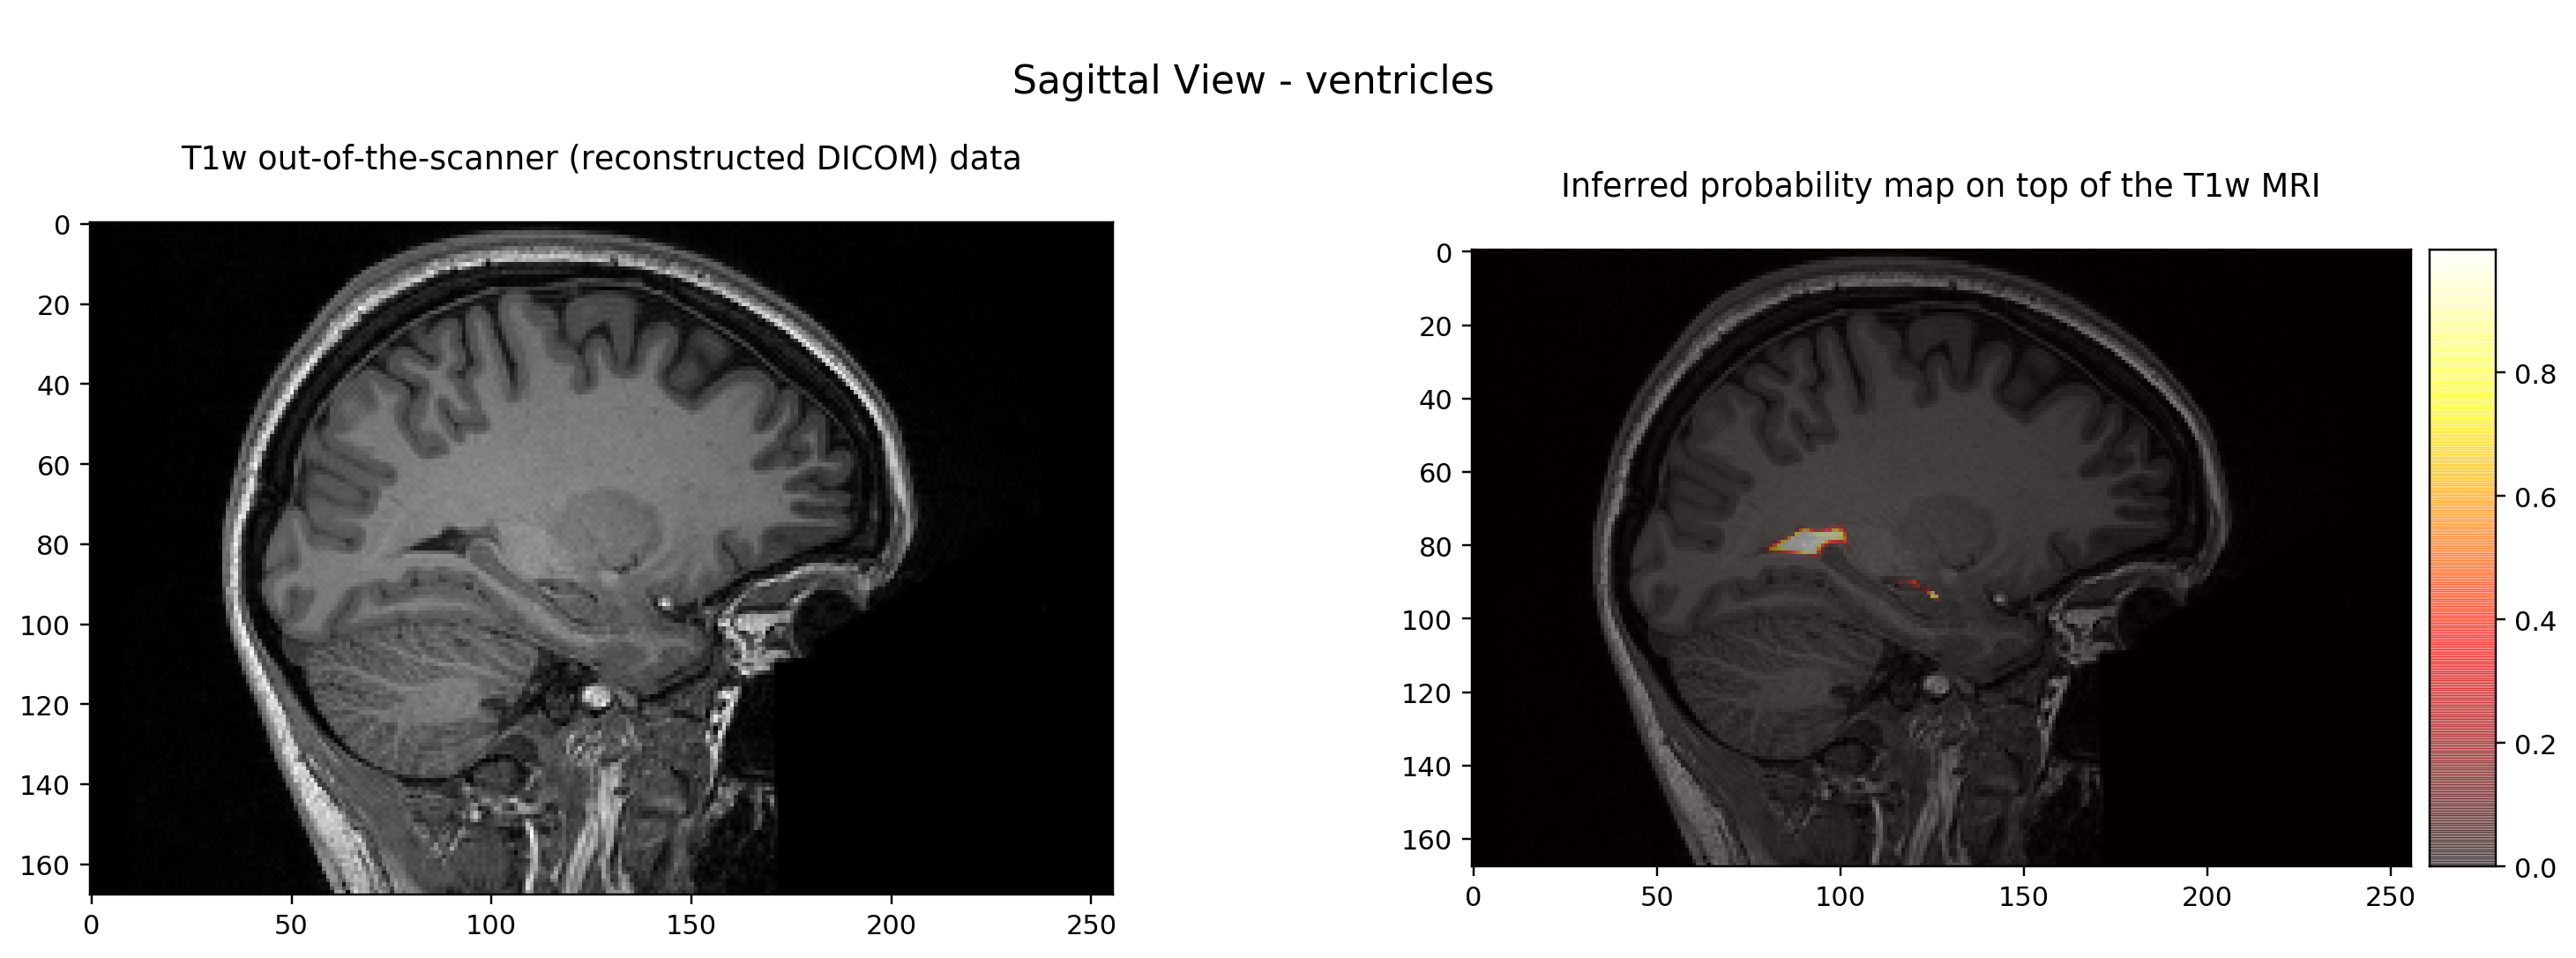

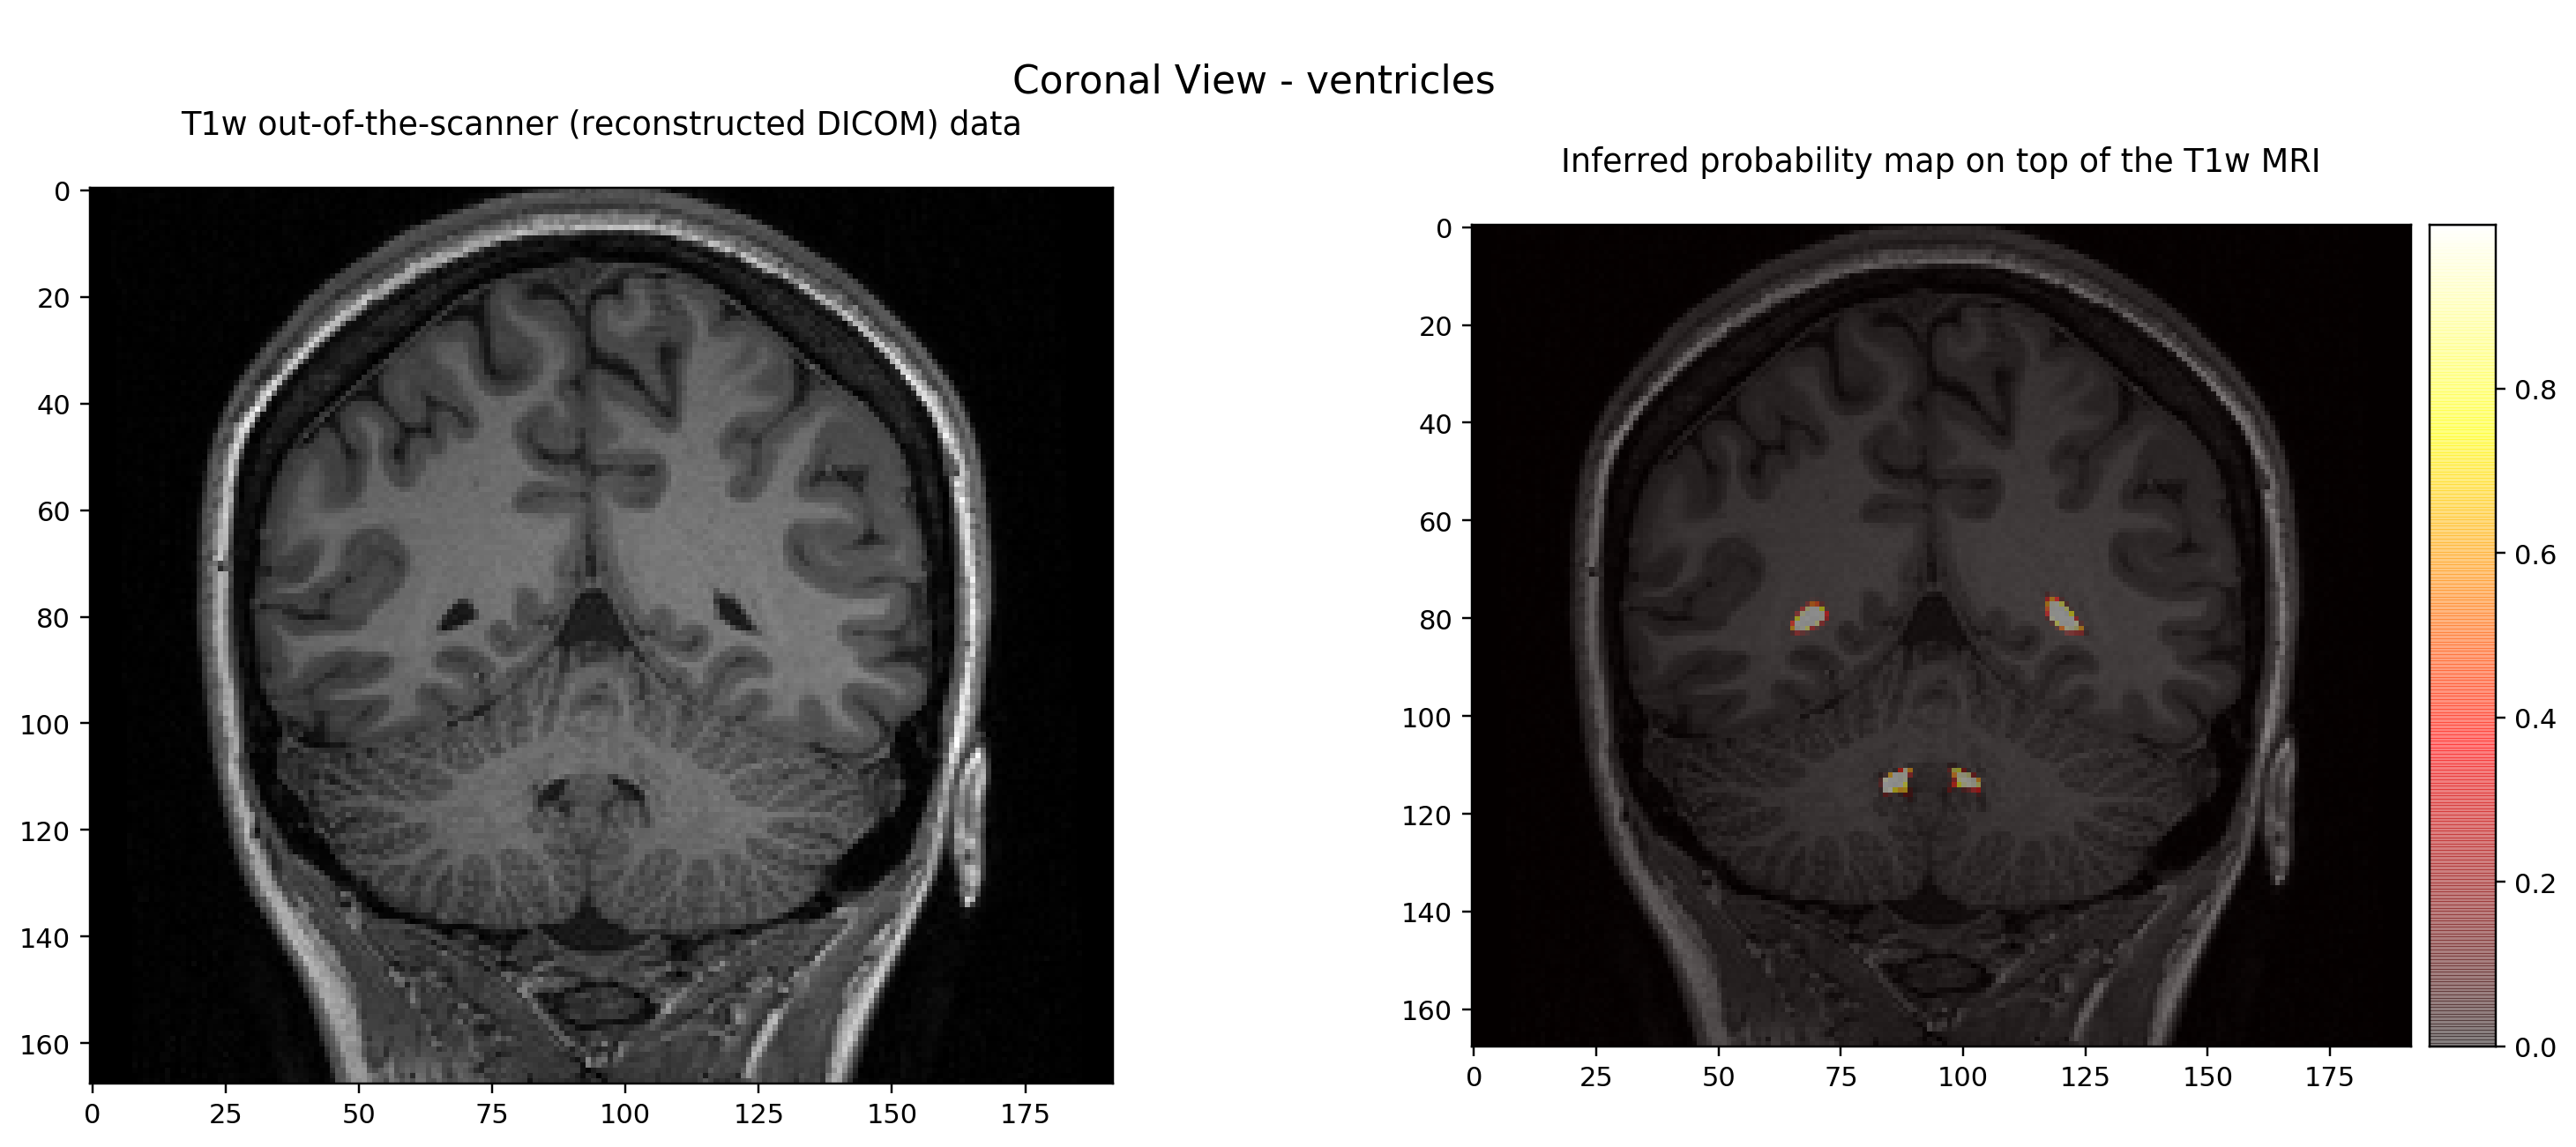

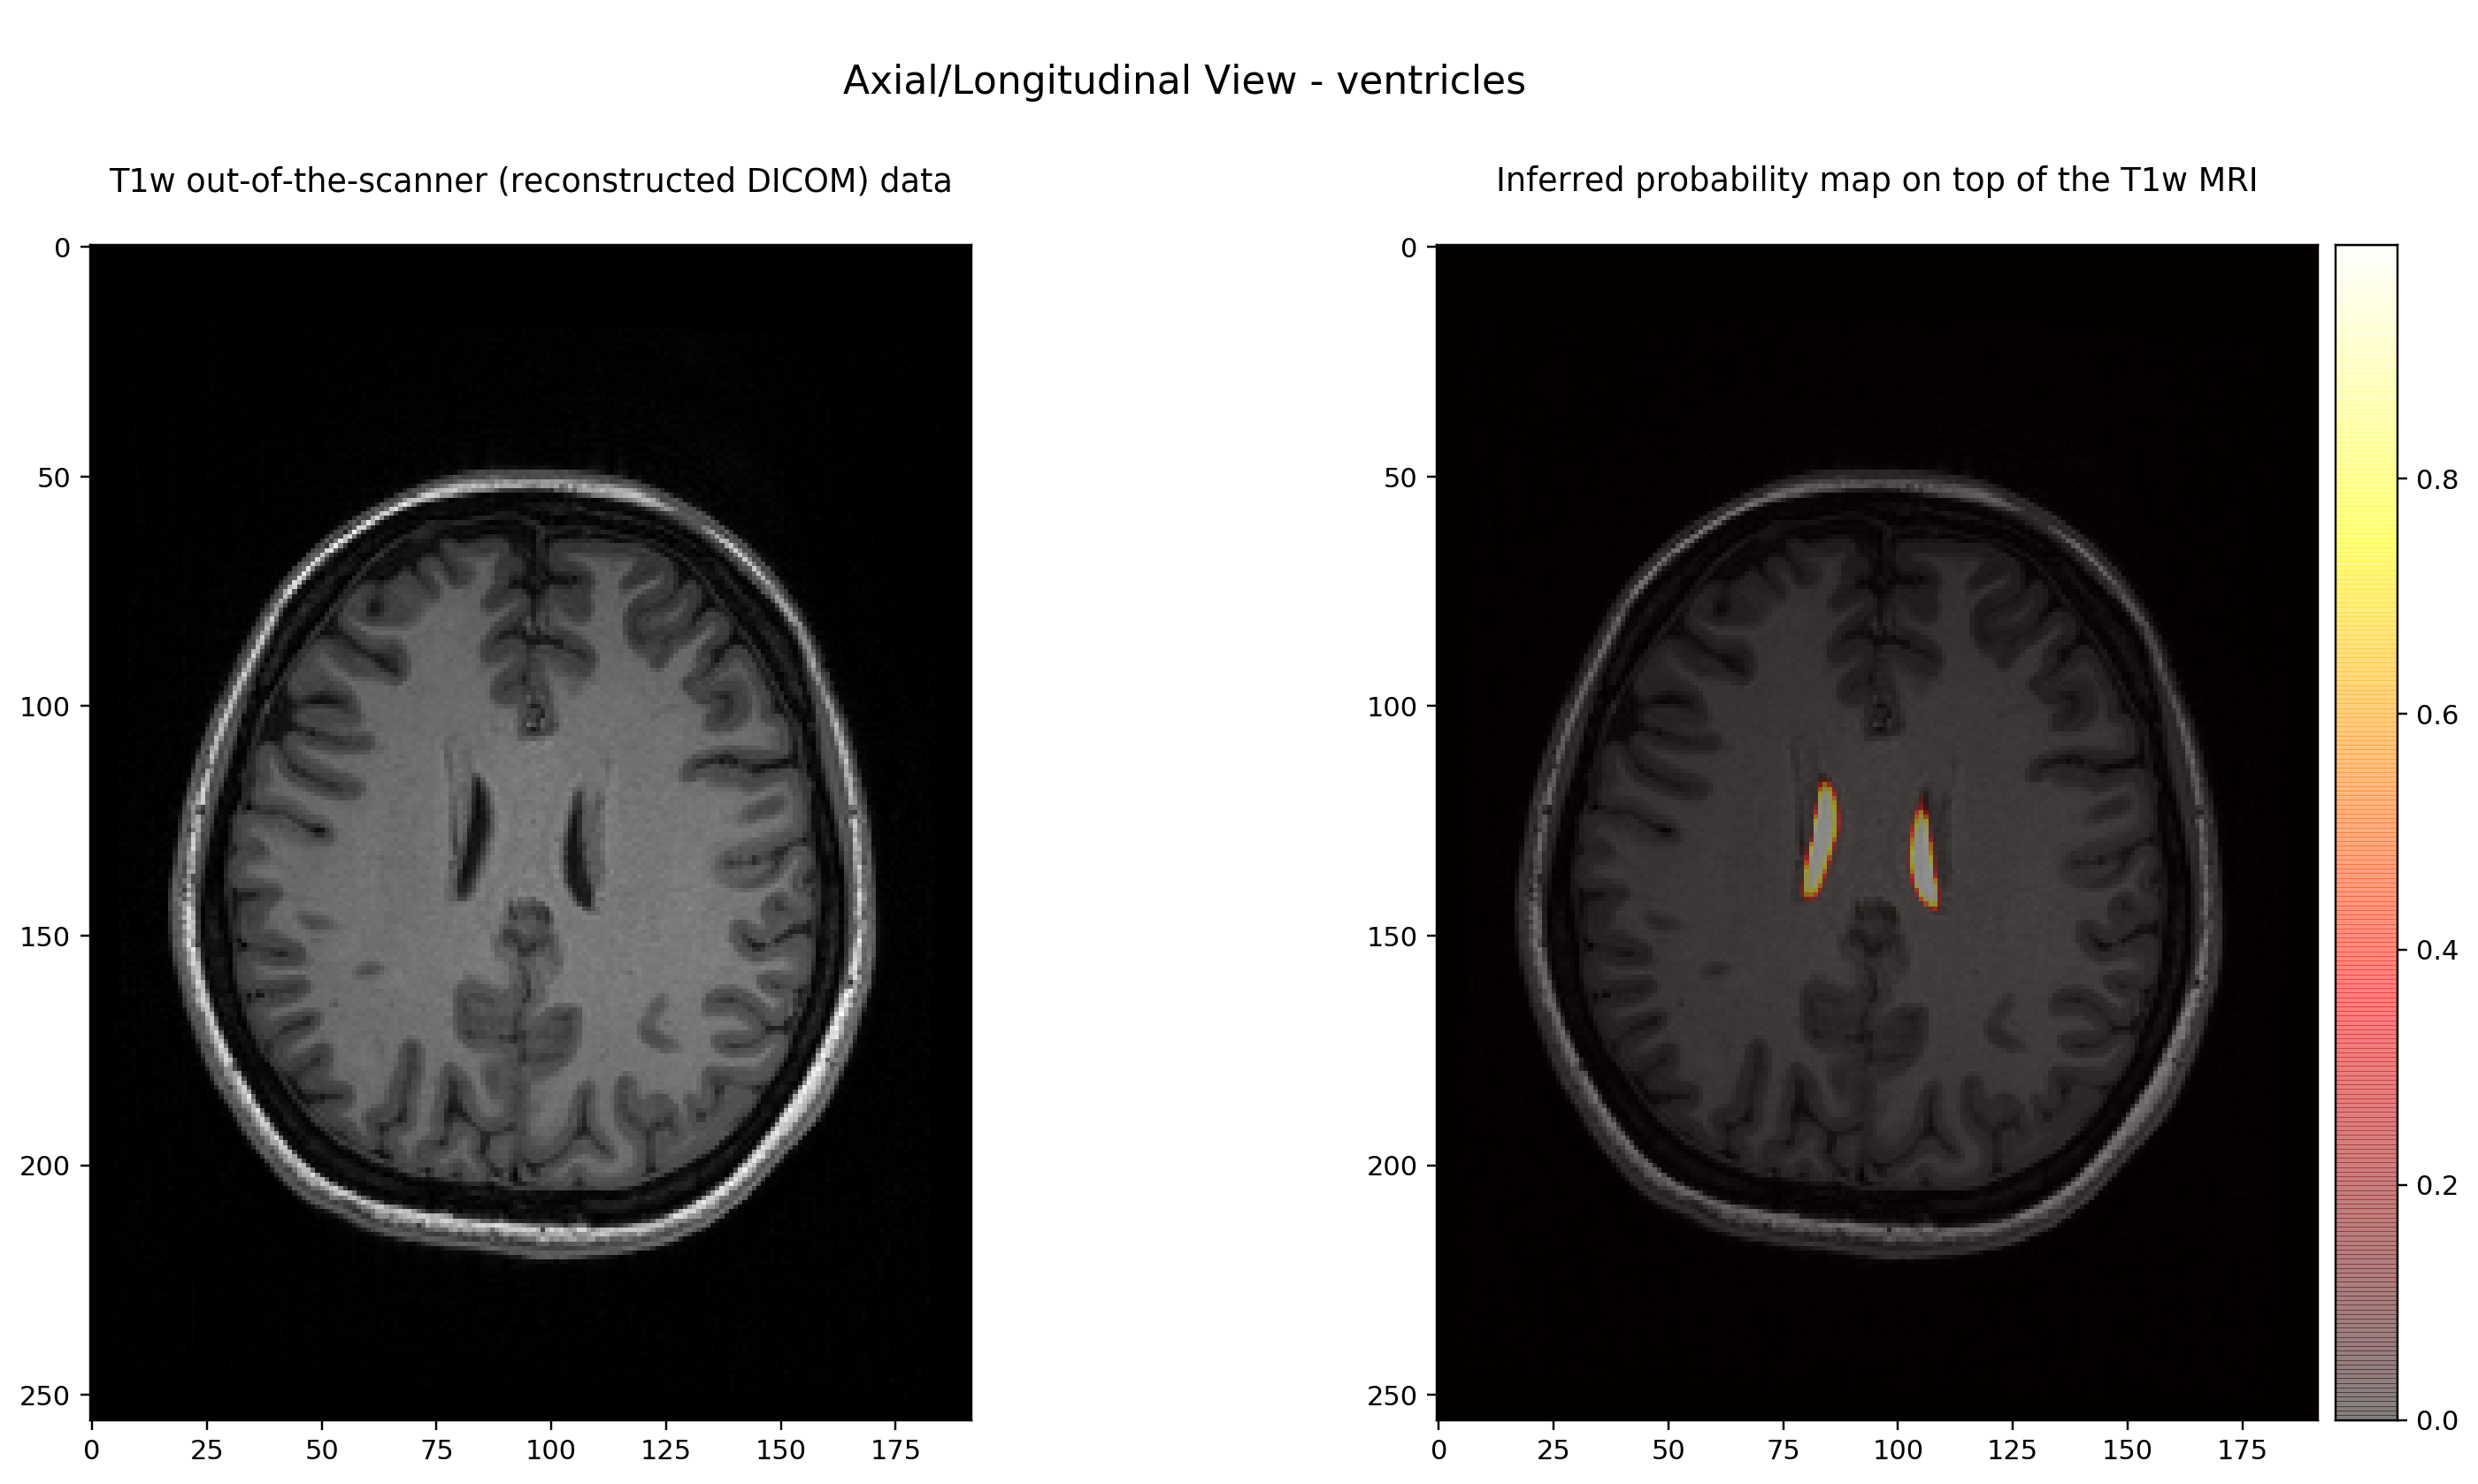

In [22]:
# tweak image size and resolution (for visualisation purposes)
plt.rcParams['figure.figsize'] = [16, 8]
matplotlib.rcParams['figure.dpi']= 220

# data is arranged such that the axes are disposed as follows:
# [sagittal, coronal, axial/longitudinal]

# ---- SAGITTAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig1, (ax11, ax12) = plt.subplots(1,2)
fig1.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im11 = ax11.imshow(np.rot90(anon_mri[selected_sag, :, :], k=1), cmap='gray')
ax11.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im12 = ax12.imshow(np.rot90(anon_mri[selected_sag, :, :], k=1), cmap='gray')
im12 = ax12.imshow(np.rot90(y_test_prob_map[selected_sag, :, :, segm_lut[selected_class]], k=1), cmap='hot', alpha = 0.5)
ax12.set_title('Inferred probability map on top of the T1w MRI\n')
ax12_divider = make_axes_locatable(ax12)
cax12 = ax12_divider.append_axes("right", size="7%", pad="2%")
cb12 = colorbar(im12, cax=cax12)

sup1 = fig1.suptitle('\nSagittal View - %s'%(classes_list[segm_lut[selected_class]]), fontsize = 'x-large', y=0.85)


# ---- CORONAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig2, (ax21, ax22) = plt.subplots(1,2)
fig2.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im21 = ax21.imshow(np.rot90(anon_mri[:, selected_cor, :], k=1), cmap='gray')
ax21.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im22 = ax22.imshow(np.rot90(anon_mri[:, selected_cor, :], k=1), cmap='gray')
im22 = ax22.imshow(np.rot90(y_test_prob_map[:, selected_cor, :, segm_lut[selected_class]], k=1), cmap='hot', alpha = 0.5)
ax22.set_title('Inferred probability map on top of the T1w MRI\n')
ax22_divider = make_axes_locatable(ax22)
cax22 = ax22_divider.append_axes("right", size="7%", pad="2%")
cb22 = colorbar(im22, cax=cax22)

sup2 = fig2.suptitle('\nCoronal View - %s'%(classes_list[segm_lut[selected_class]]), fontsize = 'x-large', y=0.9)


# ---- AXIAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig3, (ax31, ax32) = plt.subplots(1,2)
fig3.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im31 = ax31.imshow(np.rot90(anon_mri[:, :, selected_lon], k=1), cmap='gray')
ax31.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im32 = ax32.imshow(np.rot90(anon_mri[:, :, selected_lon], k=1), cmap='gray')
im32 = ax32.imshow(np.rot90(y_test_prob_map[:, :, selected_lon, segm_lut[selected_class]], k=1), cmap='hot', alpha = 0.5)
ax32.set_title('Inferred probability map on top of the T1w MRI\n')
ax32_divider = make_axes_locatable(ax32)
cax32 = ax32_divider.append_axes("right", size="7%", pad="2%")
cb32 = colorbar(im32, cax=cax32)

sup3 = fig3.suptitle('\nAxial/Longitudinal View - %s'%(classes_list[segm_lut[selected_class]]),
                     fontsize = 'x-large', y=1.025)

Once the soft segmentation maps are inferred by the model, we threshold them to get an hard-segmentation. Furthermore, we can zero-pad the data to restore the original dimension and fix the previous modifications (introduced to make data suitable for pooling).
Notice that the area we cut out is always background (assuming the acquisition was ok) - so we can zero-pad it and make it a background area in the segmentation:

In [16]:
print('Thresholding the prediction...\n\n'),

# compute the argmax (hard-thresholding) of the probability map to obtain the labelled volume
y_test_pred = np.argmax(y_test_prob_map, axis=3).astype(dtype='uint8')

for label in range(0, num_segmask_labels):
    print('Class %2d voxels: %d'%(label, np.sum(y_test_pred == label)))

pad_with = ((0, 0),
            (0, 0),
            (0, 2),
            )

y_test_pred_pad     = np.pad(y_test_pred, pad_with, mode='constant', constant_values=0)
y_test_prob_map_pad = np.pad(y_test_prob_map, pad_with + ((0, 0), ), mode='constant', constant_values=0)
y_test_prob_map_pad[:, :, 168:, 0] = 1.

print('\nDone.')

Thresholding the prediction...

Class  0 voxels: 6797993
Class  1 voxels: 453254
Class  2 voxels: 40276
Class  3 voxels: 404508
Class  4 voxels: 393596
Class  5 voxels: 11972
Class  6 voxels: 135054
Class  7 voxels: 20883

Done.


Plot the hard-segmentation using the following color code:


| Class ID | Substructure/Tissue |    Color    |
|:--------:|:-------------------:|:-----------:|
|     0    |      Background     | Transparent |
|     1    |     Grey matter     | Light green |
|     2    |    Basal ganglia    |  Dark green |
|     3    |     White matter    |     Red     |
|     4    |         CSF         |  Light blue |
|     5    |      Ventricles     |     Blue    |
|     6    |      Cerebellum     |    Yellow   |
|     7    |      Brainstem      |     Pink    |

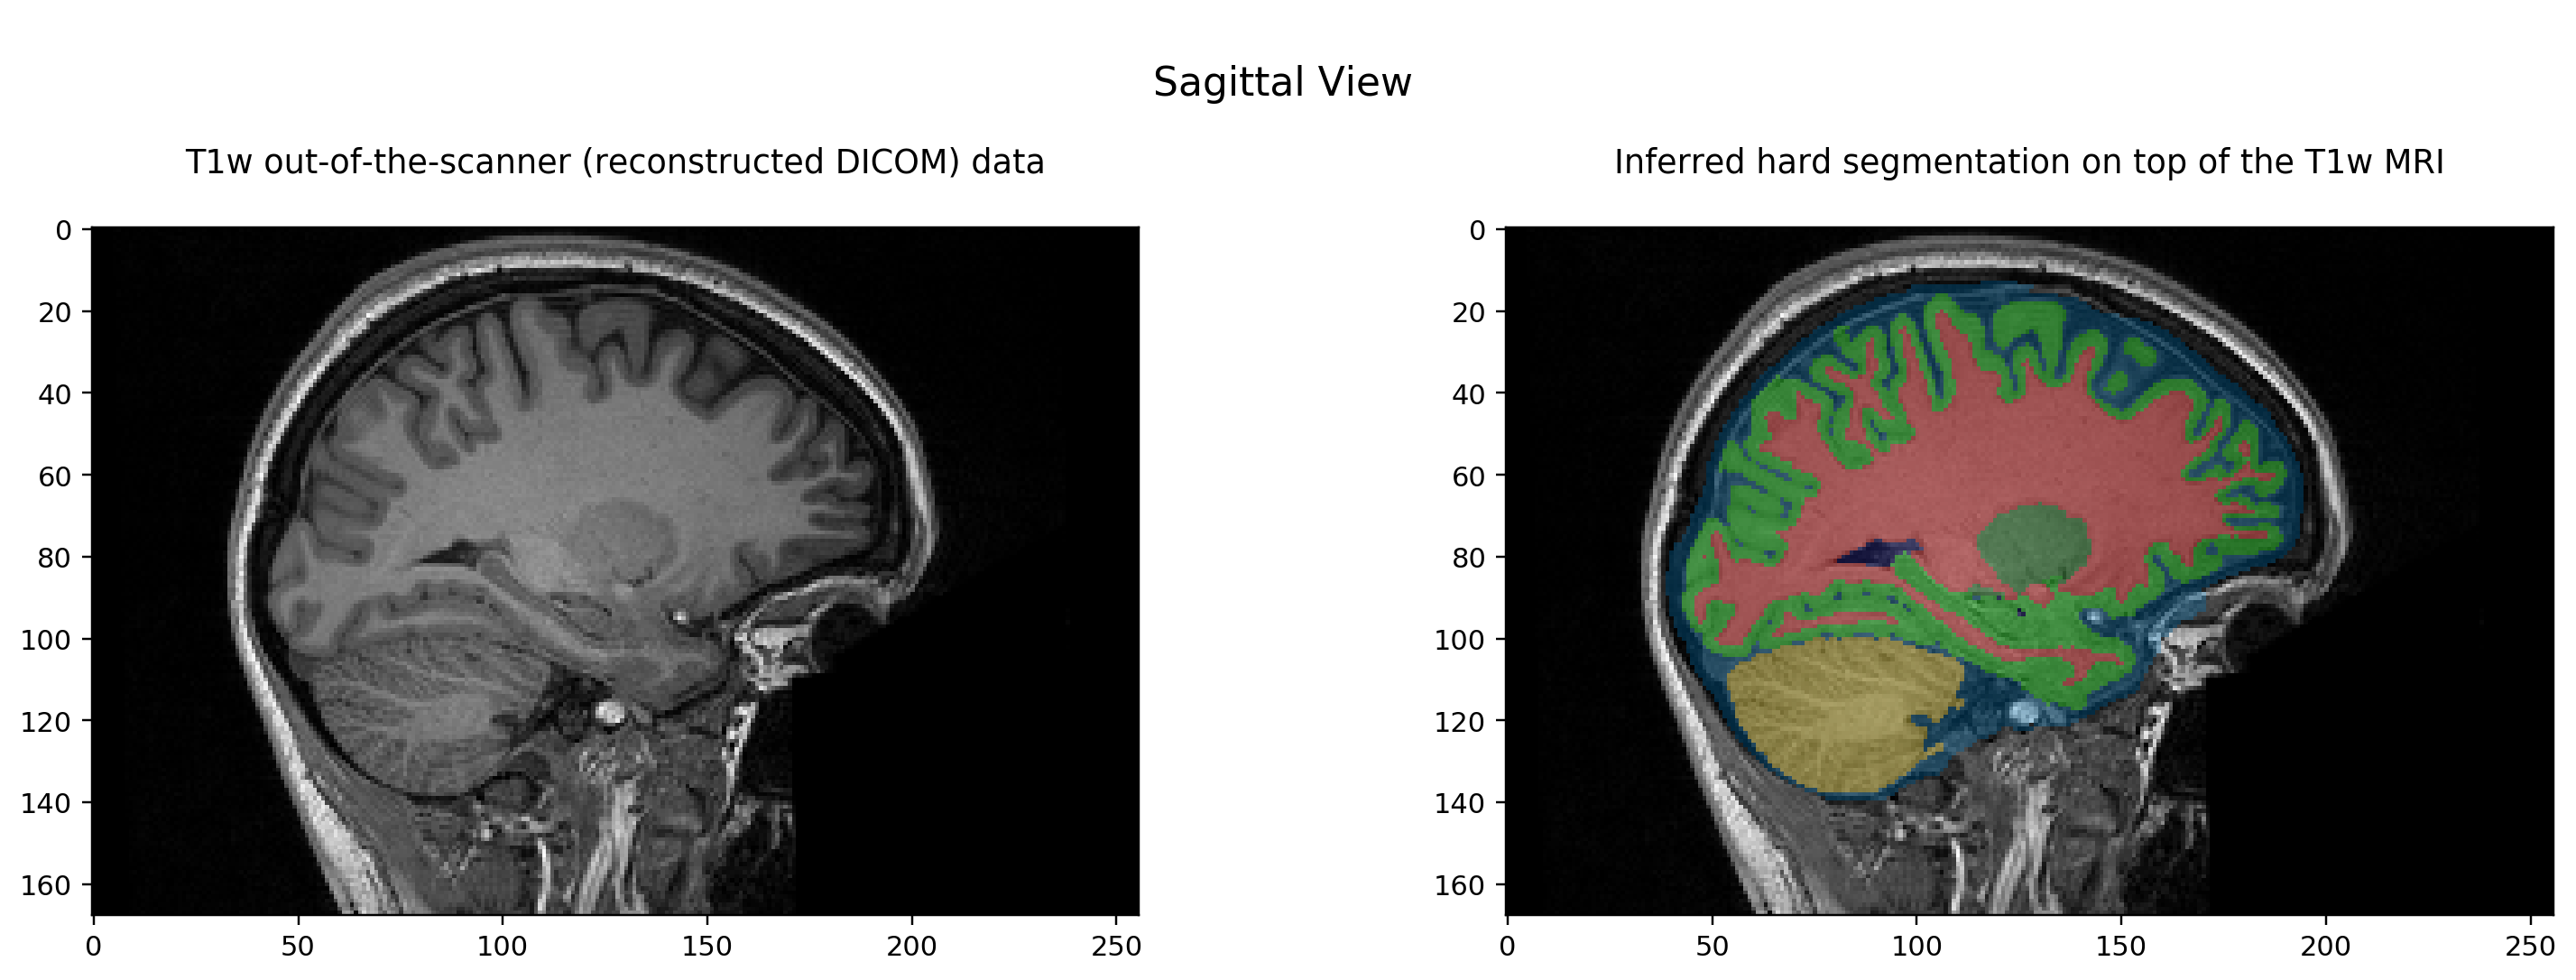

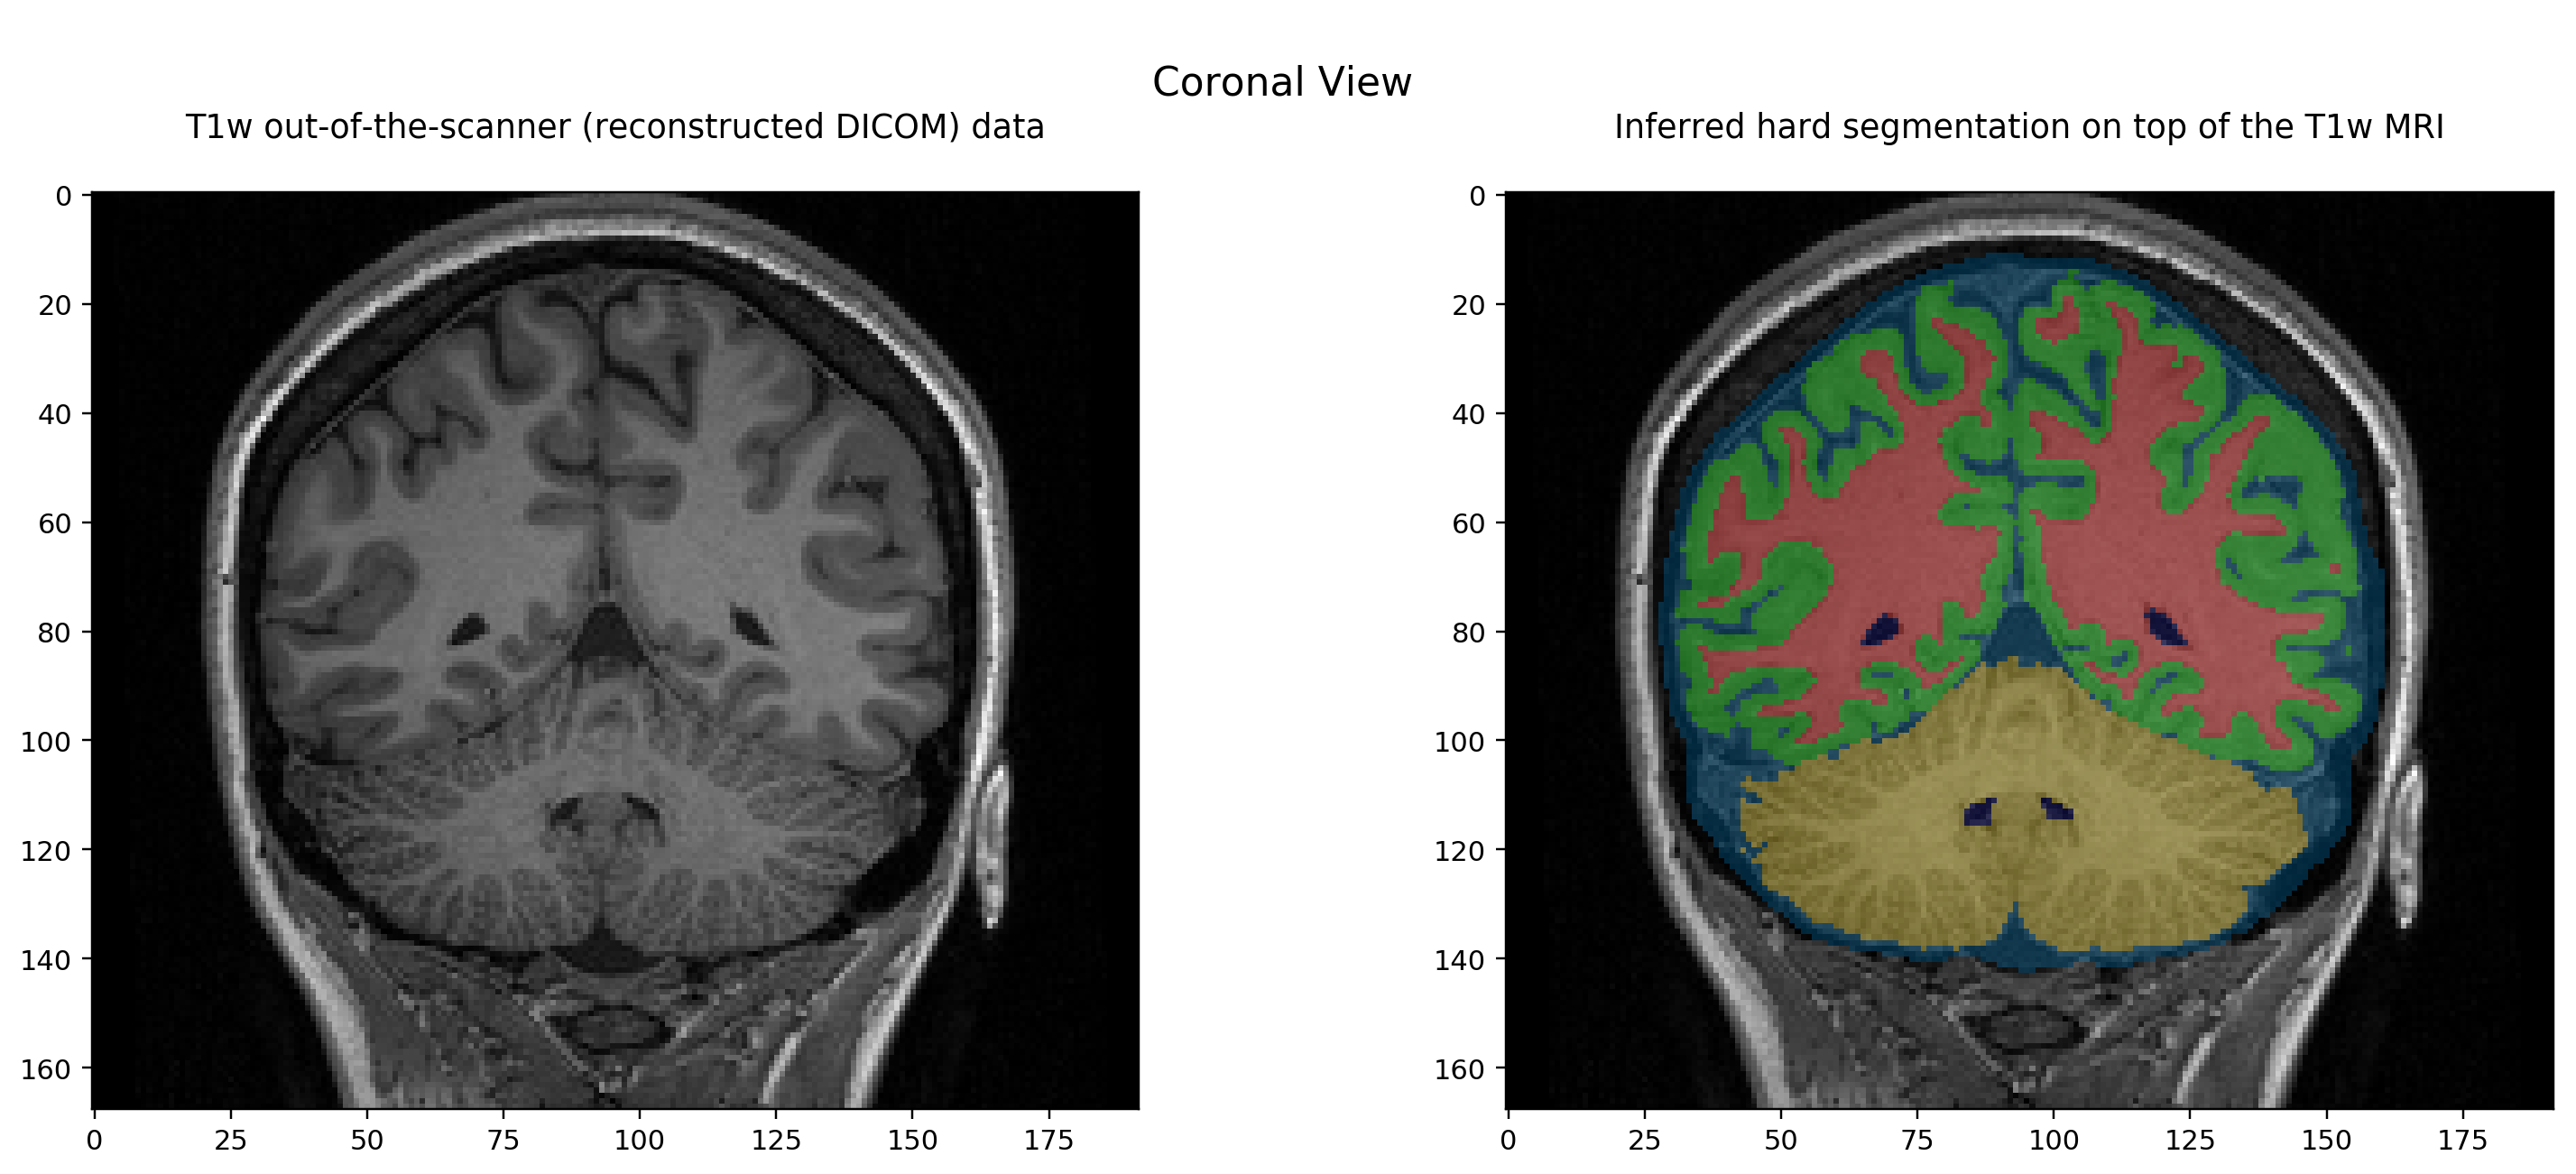

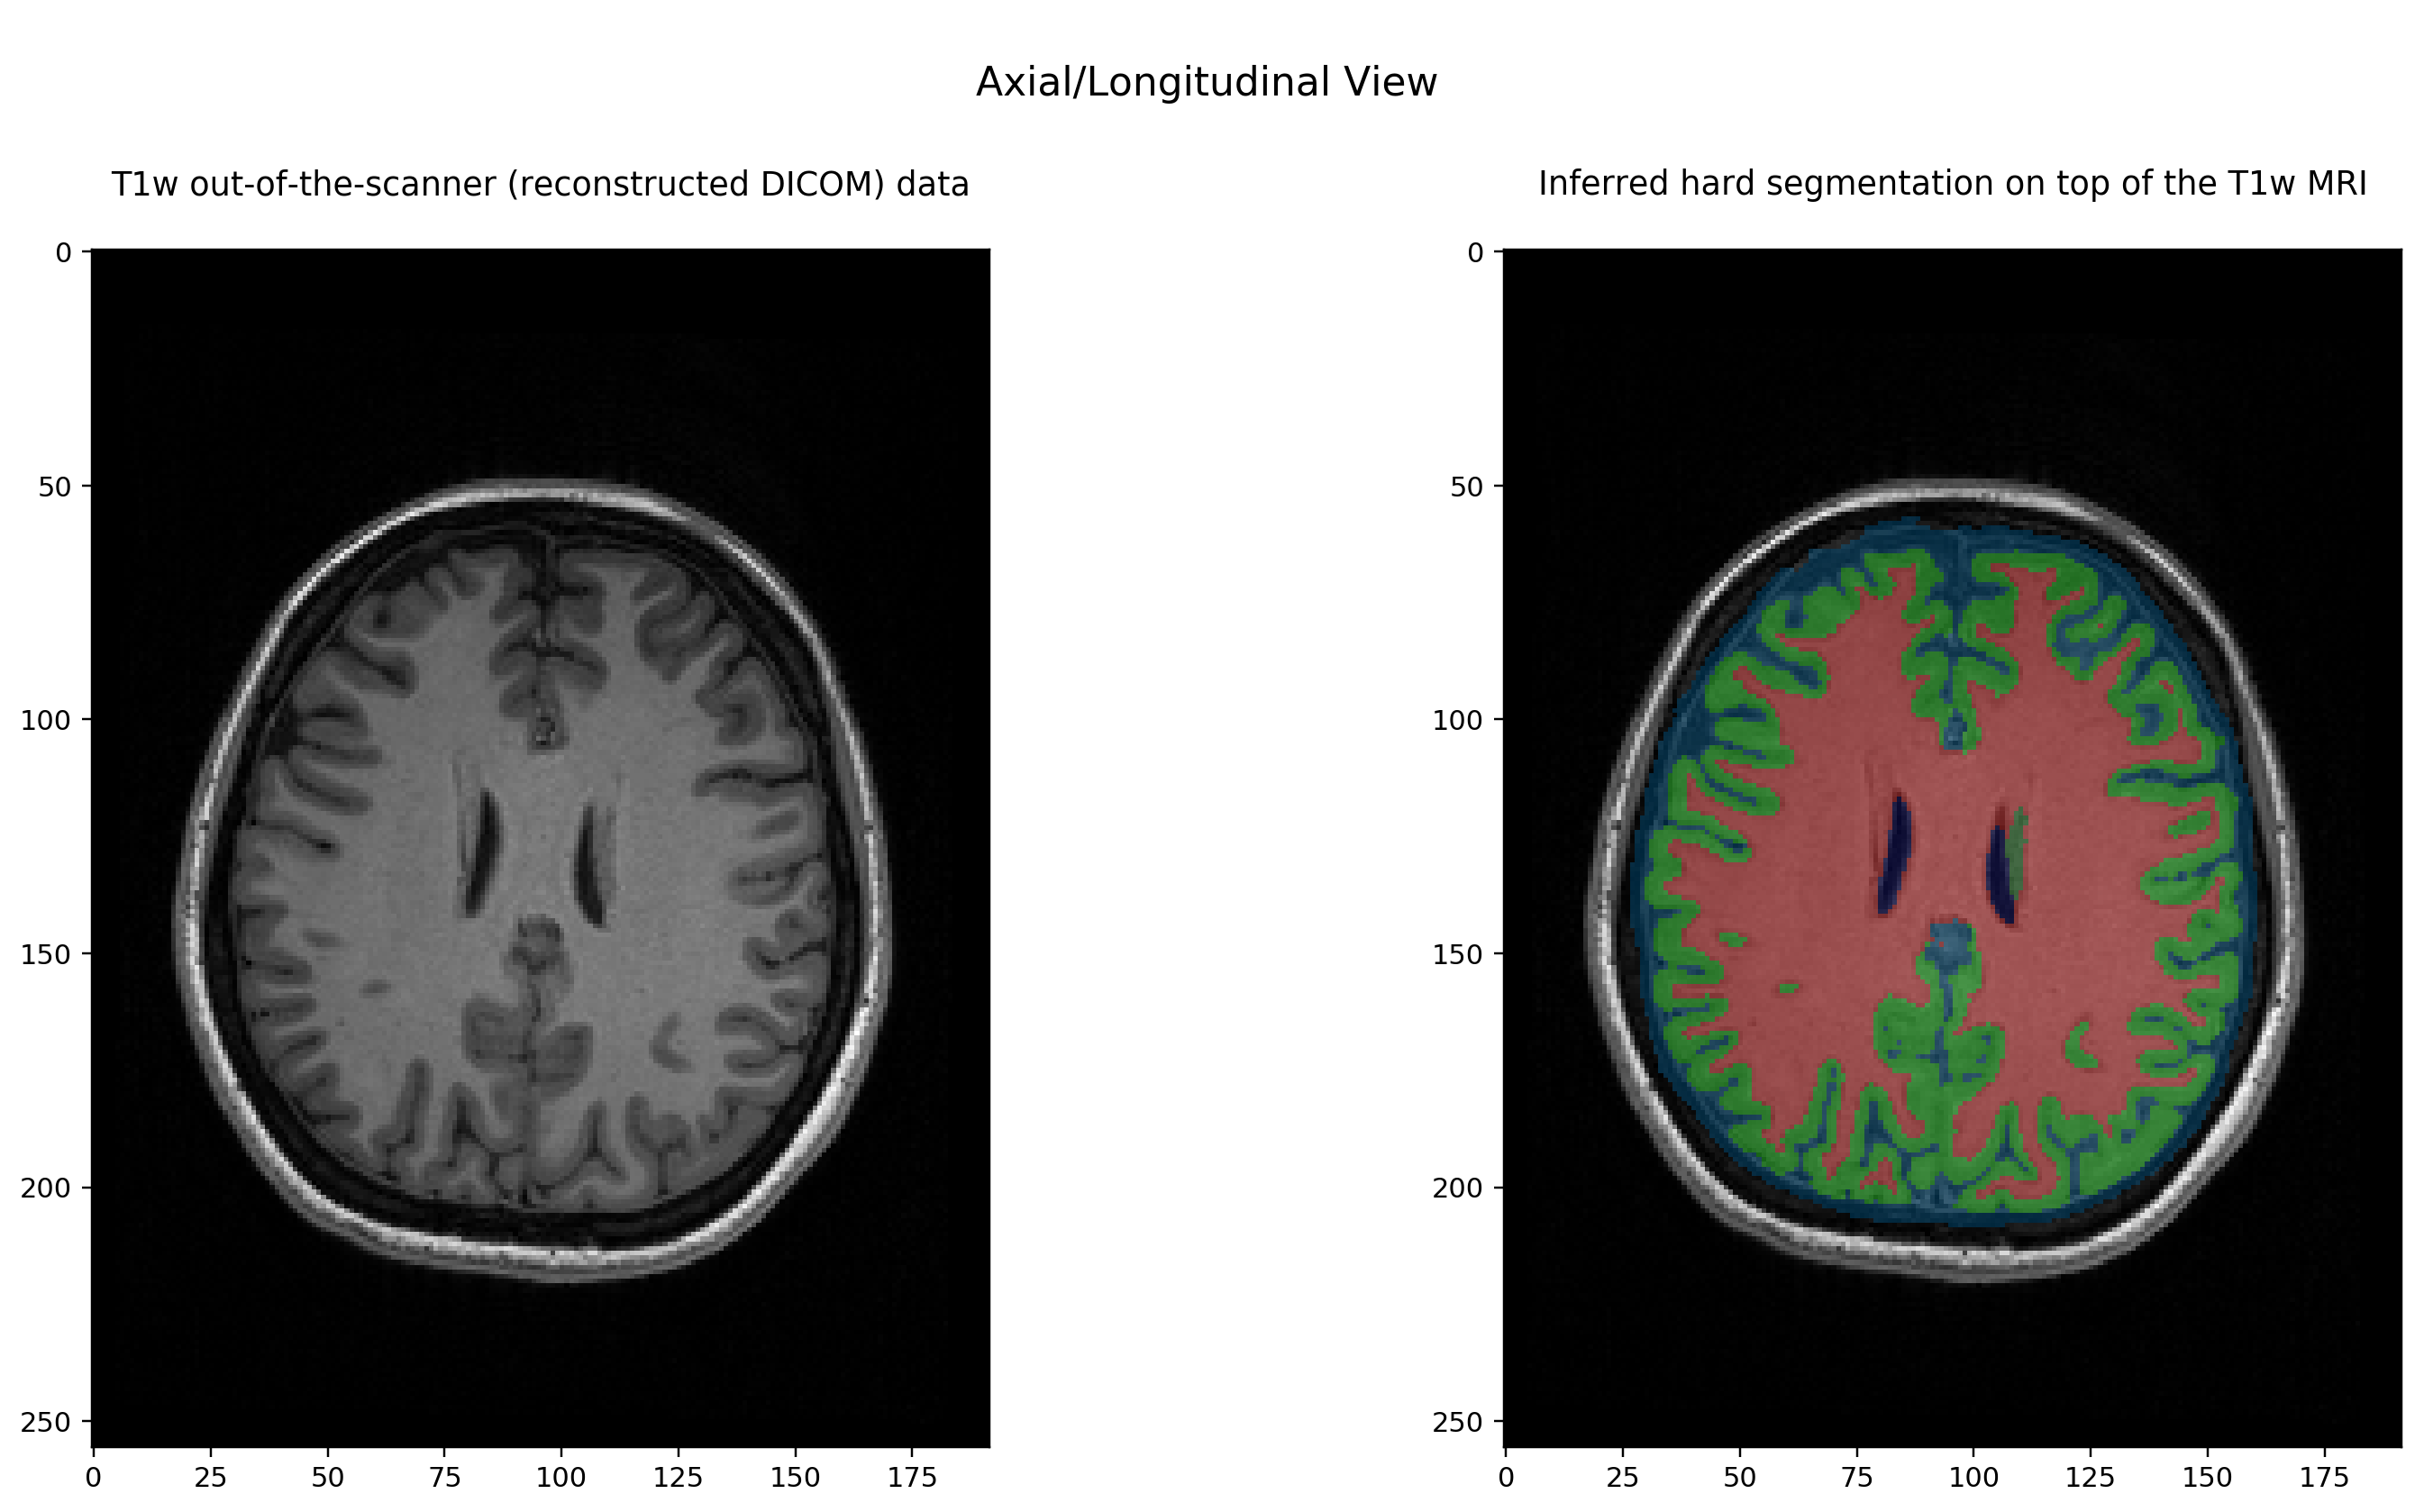

In [23]:
# ---- SAGITTAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig1, (ax11, ax12) = plt.subplots(1,2)
fig1.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im11 = ax11.imshow(np.rot90(anon_mri[selected_sag, :, :], k=1), cmap='gray')
ax11.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im12 = ax12.imshow(np.rot90(anon_mri[selected_sag, :, :], k=1), cmap='gray')
im12 = ax12.imshow(np.rot90(y_test_pred[selected_sag, :, :], k=1), cmap=my_cmap, alpha=0.3, vmin=0, vmax=7)
ax12.set_title('Inferred hard segmentation on top of the T1w MRI\n')

sup1 = fig1.suptitle('\nSagittal View', fontsize='x-large', y=0.85)


# ---- CORONAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig2, (ax21, ax22) = plt.subplots(1,2)
fig2.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im21 = ax21.imshow(np.rot90(anon_mri[:, selected_cor, :], k=1), cmap='gray')
ax21.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im22 = ax22.imshow(np.rot90(anon_mri[:, selected_cor, :], k=1), cmap='gray')
im22 = ax22.imshow(np.rot90(y_test_pred[:, selected_cor, :], k=1), cmap=my_cmap, alpha=0.3, vmin=0, vmax=7)
ax22.set_title('Inferred hard segmentation on top of the T1w MRI\n')

sup2 = fig2.suptitle('\nCoronal View', fontsize='x-large', y=0.9)


# ---- AXIAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig3, (ax31, ax32) = plt.subplots(1,2)
fig3.subplots_adjust(wspace=0.35)

# plot a slice of the anatomical MRI
im31 = ax31.imshow(np.rot90(anon_mri[:, :, selected_lon], k=1), cmap='gray')
ax31.set_title('T1w out-of-the-scanner (reconstructed DICOM) data\n')

# plot a slice of the inferred probability map on top of the anatomical MRI
im32 = ax32.imshow(np.rot90(anon_mri[:, :, selected_lon], k=1), cmap='gray')
im32 = ax32.imshow(np.rot90(y_test_pred[:, :, selected_lon], k=1), cmap=my_cmap, alpha=0.3, vmin=0, vmax=7)
ax32.set_title('Inferred hard segmentation on top of the T1w MRI\n')

sup3 = fig3.suptitle('\nAxial/Longitudinal View', fontsize='x-large', y=1.025)

Finally, save the output in NIfTI format:

In [33]:
output_directory = os.path.join('../output/segm/', dataset_name, model_name[:-3], vol_to_segment)

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

out_path = os.path.join(output_directory, vol_to_segment + segm_suffix)

print('Saving the segmentation mask at:\n%s...'%(out_path)),
sys.stdout.flush()

my_nifti = nib.Nifti1Image(y_test_pred, affine = vol_header.get_sform(), header = vol_header)
nib.save(my_nifti, out_path)

# check if everything's ok
temp = np.array(nib.load(out_path).dataobj).astype(dtype = 'uint8')

print('Done.')

## ----------------------------------------
##          OUTPUT PROBABILITY MAP
## ----------------------------------------

class_list = ['_bckgr',
              '_gm',
              '_gangl',
              '_wm',
              '_csf',
              '_ventr',
              '_cereb',
              '_bstem',
              ]

pbmaps_suffix = '_pbmaps_c3rebrum.nii.gz'

if export_prob_maps == True:

    output_directory = os.path.join('../output/pbmaps/', dataset_name, model_name[:-3], vol_to_segment)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    print('\nSaving the predicted probability maps (for each class) at:\n%s...'%(output_directory)),
    sys.stdout.flush()
    
    for label in range(1, y_test_prob_map.shape[3]):

        out_path = os.path.join(output_directory, vol_to_segment + class_list[label] + pbmaps_suffix)

        my_nifti = nib.Nifti1Image(y_test_prob_map[:, :, :, label], affine = vol_header.get_sform(), header = vol_header)
        nib.save(my_nifti, out_path)

    print('Done.')

Saving the segmentation mask at:
../output/segm/glasgow/3T/c3rebrum_strconv_48f_900_cc_paper/sub-01/sub-01_segm_c3rebrum.nii.gz... Done.

Saving the predicted probability maps (for each class) at:
../output/pbmaps/glasgow/3T/c3rebrum_strconv_48f_900_cc_paper/sub-01... Done.
